In [1]:
!pip install climate-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import climate_learn as cl
from climate_learn.data.processing.nc2npz import convert_nc2npz
from IPython.display import HTML
import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar
)
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torch

In [ ]:
cl.data.download_weatherbench(
    dst="/content/drive/MyDrive/ClimateLearn/2m_temperature",
    dataset="era5",
    variable="2m_temperature"
)

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dataserv.ub.tum.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
convert_nc2npz(
    root_dir="/content/drive/MyDrive/ClimateLearn",
    save_dir="/content/drive/MyDrive/ClimateLearn/processed",
    variables=["2m_temperature"],
    start_train_year=1979,
    start_val_year=2015,
    start_test_year=2017,
    end_year=2018,
    num_shards=16
)

100%|██████████| 1/1 [00:16<00:00, 16.55s/it]


In [44]:
dm = cl.data.IterDataModule(
    task="continuous-forecasting",
    inp_root_dir="/content/drive/MyDrive/ClimateLearn/processed",
    out_root_dir="/content/drive/MyDrive/ClimateLearn/processed",
    in_vars=["2m_temperature"],
    out_vars=["2m_temperature"],
    src="era5",
    subsample=6,
    pred_range=36,
    history=4,
    batch_size=16,
    random_lead_time = True,
    max_pred_range = 336,
)
dm.setup()

In [45]:
climatology = cl.load_forecasting_module(
    data_module=dm, architecture="climatology"
)
persistence = cl.load_forecasting_module(
    data_module=dm, architecture="persistence"
)

trainer = pl.Trainer()
trainer.test(climatology, dm)
trainer.test(persistence, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Loading architecture: climatology
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize
Loading architecture: persistence
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: de

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/lat_acc:2m_temperature  │    -0.006436604901173948     │
│    test/lat_acc:aggregate    │    -0.006436604901173948     │
│ test/lat_rmse:2m_temperature │      5.819521222947319       │
│   test/lat_rmse:aggregate    │      5.819521222947319       │
└──────────────────────────────┴──────────────────────────────┘

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric          ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test/lat_acc:2m_temperature  │      0.666528120566669       │
│    test/lat_acc:aggregate    │      0.666528120566669       │
│ test/lat_rmse:2m_temperature │      4.164740728798137       │
│   test/lat_rmse:aggregate    │      4.164740728798137       │
└──────────────────────────────┴──────────────────────────────┘

[{'test/lat_rmse:2m_temperature': 4.164740728798137,
  'test/lat_rmse:aggregate': 4.164740728798137,
  'test/lat_acc:2m_temperature': 0.666528120566669,
  'test/lat_acc:aggregate': 0.666528120566669}]

0it [00:00, ?it/s]


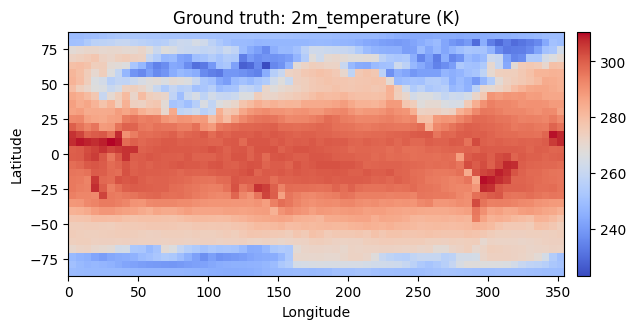

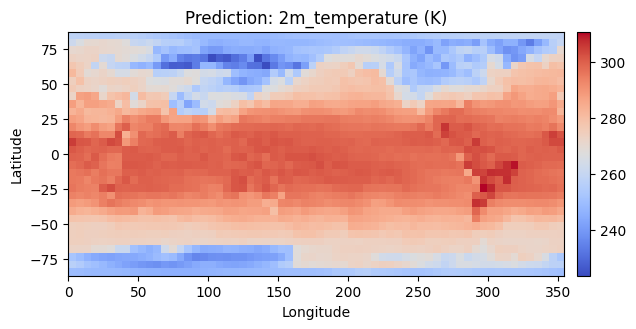

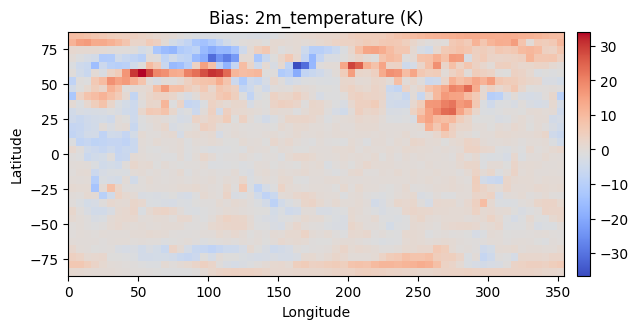

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [46]:
denorm = persistence.test_target_transforms[0]
in_graphic = cl.utils.visualize_at_index(
    persistence,
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0
)

In [10]:
NAME_TO_VAR = {
    "2m_temperature": "t2m",
    "10m_u_component_of_wind": "u10",
    "10m_v_component_of_wind": "v10",
    "mean_sea_level_pressure": "msl",
    "surface_pressure": "sp",
    "toa_incident_solar_radiation": "tisr",
    "total_precipitation": "tp",
    "land_sea_mask": "lsm",
    "orography": "orography",
    "lattitude": "lat2d",
    "geopotential": "z",
    "u_component_of_wind": "u",
    "v_component_of_wind": "v",
    "temperature": "t",
    "relative_humidity": "r",
    "specific_humidity": "q",
    "vorticity": "vo",
    "potential_vorticity": "pv",
    "total_cloud_cover": "tcc",
}

VAR_TO_NAME = {v: k for k, v in NAME_TO_VAR.items()}

SINGLE_LEVEL_VARS = [
    "2m_temperature",
    "10m_u_component_of_wind",
    "10m_v_component_of_wind",
    "mean_sea_level_pressure",
    "surface_pressure",
    "toa_incident_solar_radiation",
    "total_precipitation",
    "total_cloud_cover",
    "land_sea_mask",
    "orography",
    "lattitude",
]

PRESSURE_LEVEL_VARS = [
    "geopotential",
    "u_component_of_wind",
    "v_component_of_wind",
    "temperature",
    "relative_humidity",
    "specific_humidity",
    "vorticity",
    "potential_vorticity",
]

VAR_TO_UNIT = {
    "2m_temperature": "K",
    "10m_u_component_of_wind": "m/s",
    "10m_v_component_of_wind": "m/s",
    "mean_sea_level_pressure": "Pa",
    "surface_pressure": "Pa",
    "toa_incident_solar_radiation": "J/m^2",
    "total_precipitation": "m",
    "total_cloud_cover": None,  # dimensionless
    "land_sea_mask": None,  # dimensionless
    "orography": None,  # dimensionless
    "geopotential": "m^2/s^2",
    "u_component_of_wind": "m/s",
    "v_component_of_wind": "m/s",
    "temperature": "K",
    "relative_humidity": "%",
    "specific_humidity": "kg/kg",
    "voriticity": "1/s",
    "potential_vorticity": "K m^2 / (kg s)",
}

DEFAULT_PRESSURE_LEVELS = [50, 250, 500, 600, 700, 850, 925]

CONSTANTS = ["orography", "land_sea_mask", "slt", "lattitude", "longitude"]

NAME_LEVEL_TO_VAR_LEVEL = {}

for var in SINGLE_LEVEL_VARS:
    NAME_LEVEL_TO_VAR_LEVEL[var] = NAME_TO_VAR[var]

for var in PRESSURE_LEVEL_VARS:
    for l in DEFAULT_PRESSURE_LEVELS:
        NAME_LEVEL_TO_VAR_LEVEL[var + "_" + str(l)] = NAME_TO_VAR[var] + "_" + str(l)

VAR_LEVEL_TO_NAME_LEVEL = {v: k for k, v in NAME_LEVEL_TO_VAR_LEVEL.items()}


In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from scipy.stats import rankdata
from tqdm import tqdm

In [53]:
def visualize_at_index(mm, dm, in_transform, out_transform, variable, src, index=0):
    lat, lon = dm.get_lat_lon()
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]
    channel = dm.hparams.out_vars.index(variable)
    history = dm.hparams.history
    if src == "era5":
        variable_with_units = f"{variable} ({VAR_TO_UNIT[variable]})"
    elif src == "cmip6":
        variable_with_units = f"{variable} ({CMIP6_VAR_TO_UNIT[variable]})"
    elif src == "prism":
        variable_with_units = f"Daily Max Temperature (C)"
    else:
        raise NotImplementedError(f"{src} is not a supported source")

    counter = 0
    adj_index = None
    for batch in tqdm(dm.test_dataloader()):
        x, y = batch[:2]
        batch_size = x.shape[0]
        if index in range(counter, counter + batch_size):
            adj_index = index - counter
            x = x.to(mm.device)
            pred = mm.forward(x)
            break
        counter += batch_size

    if adj_index is None:
        raise RuntimeError("Given index could not be found")
    xx = x[adj_index]
    print('before: ', xx.shape)
    print(xx[:, 1, :, :])
    if dm.hparams.task == "continuous-forecasting":
        xx = xx[:, :-1, :, :]

    print('after: ', xx.shape)

    # Create animation/plot of the input sequence
    if history > 1:
        in_fig, in_ax = plt.subplots()
        in_ax.set_title(f"Input Sequence: {variable_with_units}")
        in_ax.set_xlabel("Longitude")
        in_ax.set_ylabel("Latitude")
        imgs = []
        for time_step in range(history):
            img = in_transform(xx[time_step])[channel].detach().cpu().numpy()
            if src == "era5":
                img = np.flip(img, 0)
            img = in_ax.imshow(img, cmap=plt.cm.coolwarm, animated=True, extent=extent)
            imgs.append([img])
        cax = in_fig.add_axes(
            [
                in_ax.get_position().x1 + 0.02,
                in_ax.get_position().y0,
                0.02,
                in_ax.get_position().y1 - in_ax.get_position().y0,
            ]
        )
        in_fig.colorbar(in_ax.get_images()[0], cax=cax)
        anim = animation.ArtistAnimation(in_fig, imgs, interval=1000, repeat_delay=2000)
        plt.close()
    else:
        if dm.hparams.task == "downscaling":
            img = in_transform(xx)[channel].detach().cpu().numpy()
        else:
            img = in_transform(xx[0])[channel].detach().cpu().numpy()
        if src == "era5":
            img = np.flip(img, 0)
        visualize_sample(img, extent, f"Input: {variable_with_units}")
        anim = None
        plt.show()

    # Plot the ground truth
    yy = out_transform(y[adj_index])
    yy = yy[channel].detach().cpu().numpy()
    if src == "era5":
        yy = np.flip(yy, 0)
    visualize_sample(yy, extent, f"Ground truth: {variable_with_units}")
    plt.show()

    # Plot the prediction
    ppred = out_transform(pred[adj_index])
    ppred = ppred[channel].detach().cpu().numpy()
    if src == "era5":
        ppred = np.flip(ppred, 0)
    visualize_sample(ppred, extent, f"Prediction: {variable_with_units}")
    plt.show()

    # Plot the bias
    bias = ppred - yy
    visualize_sample(bias, extent, f"Bias: {variable_with_units}")
    plt.show()

    # None, if no history
    return anim

In [38]:
def visualize_sample(img, extent, title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    cmap = plt.cm.coolwarm
    cmap.set_bad("black", 1)
    ax.imshow(img, cmap=cmap, extent=extent)
    cax = fig.add_axes(
        [
            ax.get_position().x1 + 0.02,
            ax.get_position().y0,
            0.02,
            ax.get_position().y1 - ax.get_position().y0,
        ]
    )
    fig.colorbar(ax.get_images()[0], cax=cax)
    return (fig, ax)

0it [00:00, ?it/s]


before:  torch.Size([4, 2, 32, 64])
tensor([[[0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         ...,
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100]],

        [[0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         ...,
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100]],

        [[0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         [0.4100, 0.4100, 0.4100,  ..., 0.4100, 0.4100, 0.4100],
         [0.4100, 0.41

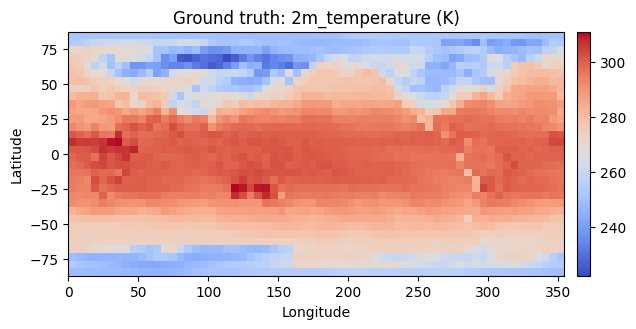

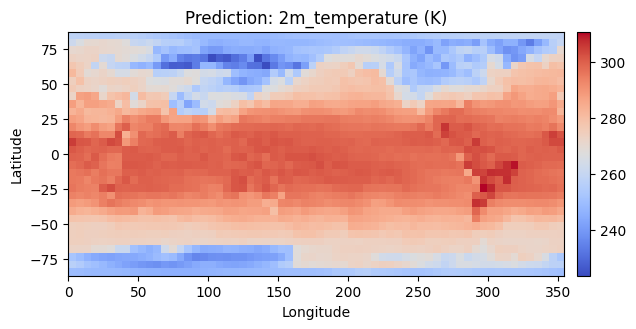

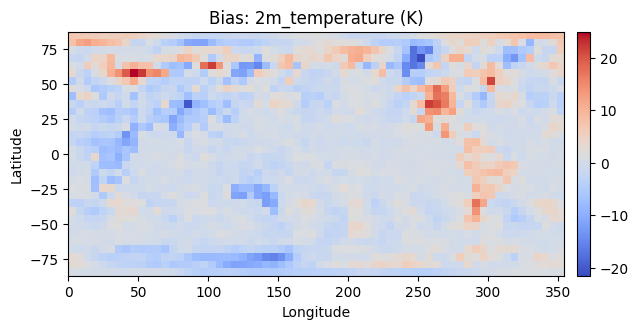

In [54]:
visualize_at_index(
    persistence,
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0
)

In [ ]:
HTML(in_graphic.to_jshtml())

17it [00:00, 26.16it/s]


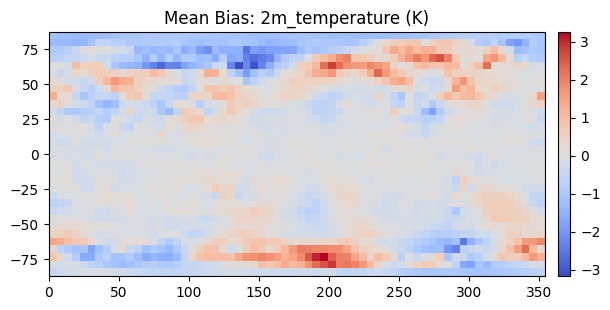

In [ ]:
cl.utils.visualize_mean_bias(
    dm,
    persistence,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5"
)

In [ ]:
resnet = cl.load_forecasting_module(
    data_module=dm,
    architecture="rasp-theurey-2020"
)

Loading architecture: rasp-theurey-2020
Using optimizer associated with architecture
Using learning rate scheduler associated with architecture
Loading training loss: lat_mse
No train transform
Loading validation loss: lat_rmse
Loading validation loss: lat_acc
Loading validation loss: lat_mse
Loading validation transform: denormalize
Loading validation transform: denormalize
No validation transform
Loading test loss: lat_rmse
Loading test loss: lat_acc
Loading test transform: denormalize
Loading test transform: denormalize


In [ ]:
pl.seed_everything(0)
default_root_dir = f"resnet_forecasting_24hrs"
logger = TensorBoardLogger(save_dir=f"{default_root_dir}/logs")
early_stopping = "val/lat_mse:aggregate"
callbacks = [
    RichProgressBar(),
    RichModelSummary(max_depth=1),
    EarlyStopping(
        monitor=early_stopping,
        patience=5
    ),
    ModelCheckpoint(
        dirpath=f"{default_root_dir}/checkpoints",
        monitor=early_stopping,
        filename="epoch_{epoch:03d}",
        auto_insert_metric_name=False,
    )
]
trainer = pl.Trainer(
    logger=logger,
    callbacks=callbacks,
    default_root_dir=default_root_dir,
    accelerator="gpu" if torch.cuda.is_available() else None,
    devices=[0] if torch.cuda.is_available() else None,
    max_epochs=1,
    precision="16"
)

INFO:lightning_fabric.utilities.seed:Seed set to 0
/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(resnet, datamodule=dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type   ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ 0 │ net  │ ResNet │  5.6 M │
└───┴──────┴────────┴────────┘

Trainable params: 5.6 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.6 M                                                                                                
Total estimated model params size (MB): 22

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


0it [00:00, ?it/s]


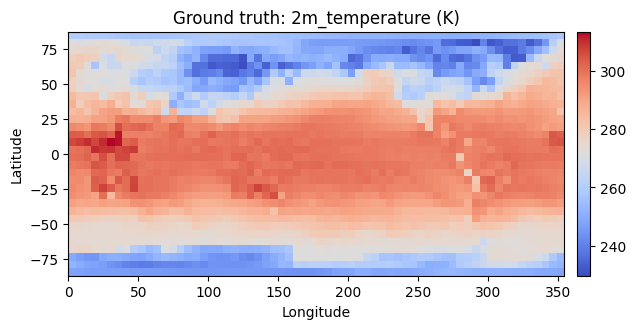

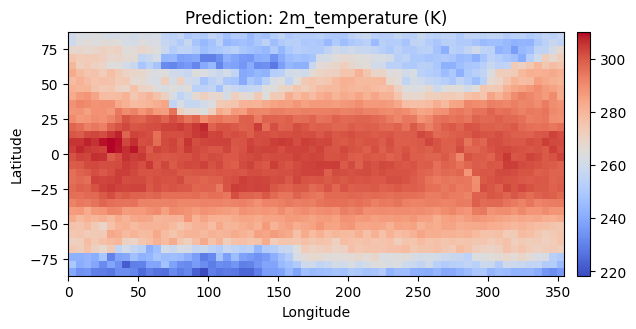

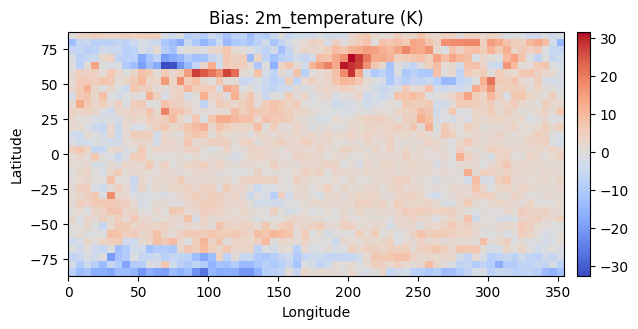

In [ ]:
denorm = resnet.test_target_transforms[0]
in_graphic = cl.utils.visualize_at_index(
    resnet.to(device="cuda:0"),
    dm,
    in_transform=denorm,
    out_transform=denorm,
    variable="2m_temperature",
    src="era5",
    index=0
)